# Import librairies

In [1]:
import pandas as pd
from datetime import date
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Import des datasets

In [2]:
df_global = pd.read_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet')

In [3]:
df_prediction_taux_occupation = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/taux_occupation_predictions.csv')

# Test 1 - RandomForest incluant taux_occupation prédit en cible multiclasse

Prédiction avec un RandomForest sur du multiclasse incluant la variable temporelle précédemment prédite taux_occupation

In [8]:
# --- Préparation des données ---

df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')

train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()
predict_base_df = df_global[df_global['heure_arrondie'] >= cutoff_date].copy()

# Selection des variables explicatives
feature_cols = ['taux_occupation', 'id', 'weekday', 'hour', 'is_vacances', 'is_ferie', 'has_event_near_troncon']
target_col = 'code_couleur'


# --- Fusion des données ---

# Objectif : retrouver les features correspondant aux prédictions
# On utilise 'nom_du_troncon' et 'heure_arrondie' pour lier la prédiction du LSTM aux données de contexte de df_global
predict_df_merged = pd.merge(
    predict_base_df,
    df_prediction_taux_occupation,
    on=['heure_arrondie', 'nom_du_troncon'], 
    how='inner' 
)

# Remplacer la valeur réelle par la valeur prédite
predict_df_merged['taux_occupation'] = predict_df_merged['taux_occupation_pred']
# Supprimer la colonne de prédiction pour ne pas la retrouver dans les features
predict_df_merged = predict_df_merged.drop(columns=['taux_occupation_pred'])

# --- Encodage uniforme ---
X_train_data = train_df[feature_cols]
# On prend les mêmes colonnes du df fusionné
X_pred_data = predict_df_merged[feature_cols]

# Combinaison pour encodage robuste
X_train_data['source'] = 'train'
X_pred_data['source'] = 'pred'
combined_df = pd.concat([X_train_data, X_pred_data], ignore_index=True)

categorical_cols = ['id', 'hour', 'weekday']
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols, dtype=int)

X_train_final = combined_df_encoded[combined_df_encoded['source'] == 'train'].drop(columns=['source'])
X_to_predict = combined_df_encoded[combined_df_encoded['source'] == 'pred'].drop(columns=['source'])
y_train = train_df[target_col]
X_to_predict = X_to_predict[X_train_final.columns]

# --- Entraînement du modèle ---
print("Entraînement du modèle")
model = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1
)
model.fit(X_train_final, y_train)
print("Modèle entraîné.")

# --- Prédiction ---
predictions = model.predict(X_to_predict)

# Ajouter les prédictions au DataFrame fusionné pour garder une trace
predict_df_merged['code_couleur_predit'] = predictions

# Ajouter la colonne de prédiction à votre DataFrame original en utilisant la même clé de jointure
df_prediction_taux_occupation = pd.merge(
    df_prediction_taux_occupation,
    predict_df_merged[['heure_arrondie', 'nom_du_troncon', 'code_couleur_predit']],
    on=['heure_arrondie', 'nom_du_troncon'],
    how='left'
)

<ipython-input-8-7d6ef9ab8072>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_data['source'] = 'train'
<ipython-input-8-7d6ef9ab8072>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_data['source'] = 'pred'


Entraînement du modèle
Modèle entraîné.


## Evaluation


--- Rapport de Classification ---
Analyse de la performance pour chaque code couleur :


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

              precision    recall  f1-score   support

         3.0       0.98      1.00      0.99    422099
         4.0       0.00      0.00      0.00      4501
         5.0       0.00      0.00      0.00      2139
         6.0       0.00      0.00      0.00      2685

    accuracy                           0.98    431424
   macro avg       0.24      0.25      0.25    431424
weighted avg       0.96      0.98      0.97    431424


--- Matrice de Confusion ---
Visualisation des erreurs de classification :


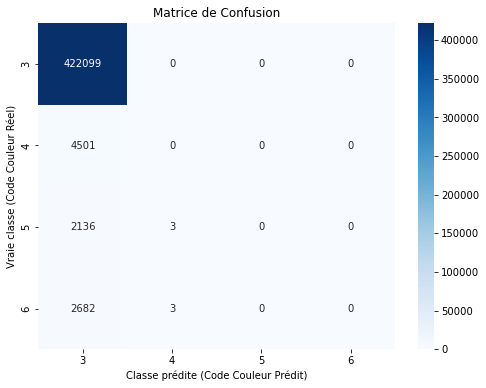

In [9]:

# ---  Évaluation détaillée de la performance ---

# 1. Définir les vraies valeurs et les valeurs prédites
# Les vraies valeurs pour la période de test
y_true = predict_df_merged['code_couleur']

# Les prédictions que nous venons de faire
y_pred = predictions


# Générer et afficher le Rapport de Classification
print("\n--- Rapport de Classification ---")
print("Analyse de la performance pour chaque code couleur :")
print(classification_report(y_true, y_pred))


# Matrice de confusion
print("\n--- Matrice de Confusion ---")
print("Visualisation des erreurs de classification :")

labels = sorted(y_true.astype(int).unique())

cm = confusion_matrix(y_true, y_pred, labels=labels)

# Affichage 
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe (Code Couleur Réel)')
plt.xlabel('Classe prédite (Code Couleur Prédit)')
plt.show()

## Test 2 - RandomForest incluant taux_occupation prédit en cible binaire

Prédiction avec un RandomForest sur du binaire (Fluide/non-fluide) incluant la variable temporelle précédemment prédite : taux_occupation

<ipython-input-4-b57c2a73591f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_data['source'] = 'train'
<ipython-input-4-b57c2a73591f>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_data['source'] = 'pred'


Modèle entraîné.

--- Rapport de Classification Binaire ---


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

                precision    recall  f1-score   support

    Fluide (0)       0.98      1.00      0.99    422099
Non Fluide (1)       0.00      0.00      0.00      9325

      accuracy                           0.98    431424
     macro avg       0.49      0.50      0.49    431424
  weighted avg       0.96      0.98      0.97    431424


--- Matrice de Confusion Binaire ---


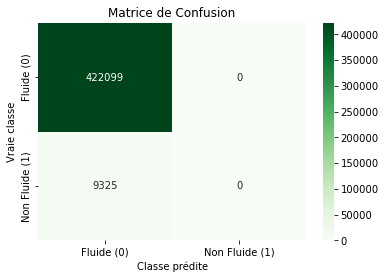

In [4]:
def map_to_binary(code):
  if code == 3:
    return 0  # Représente 'fluide'
  else:
    return 1  # Représente 'non fluide' (regroupe 4, 5, et 6)

df_global['is_congested'] = df_global['code_couleur'].apply(map_to_binary)

# --- Préparation des données ---
df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')

train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()
predict_base_df = df_global[df_global['heure_arrondie'] >= cutoff_date].copy()

feature_cols = ['taux_occupation', 'id', 'weekday', 'hour', 'is_vacances', 'is_ferie', 'has_event_near_troncon']
target_col = 'is_congested'

# --- Fusion ---
predict_df_merged = pd.merge(
    predict_base_df,
    df_prediction_taux_occupation,
    on=['heure_arrondie', 'nom_du_troncon'],
    how='inner'
)
predict_df_merged['taux_occupation'] = predict_df_merged['taux_occupation_pred']
predict_df_merged = predict_df_merged.drop(columns=['taux_occupation_pred'])


# --- Encodage ---
X_train_data = train_df[feature_cols]
X_pred_data = predict_df_merged[feature_cols]
X_train_data['source'] = 'train'
X_pred_data['source'] = 'pred'
combined_df = pd.concat([X_train_data, X_pred_data], ignore_index=True)
categorical_cols = ['id', 'hour', 'weekday']
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols, dtype=int)
X_train_final = combined_df_encoded[combined_df_encoded['source'] == 'train'].drop(columns=['source'])
X_to_predict = combined_df_encoded[combined_df_encoded['source'] == 'pred'].drop(columns=['source'])
y_train = train_df[target_col] 
X_to_predict = X_to_predict[X_train_final.columns]


# --- Entraînement  ---
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_final, y_train)
print("Modèle entraîné.")


# --- Prédiction  ---

predictions_binary = model.predict(X_to_predict)

# Ajouter la prédiction binaire (0 ou 1)
df_prediction_taux_occupation['is_congested_predit'] = predictions_binary

# Ajouter une colonne avec des labels clairs pour une meilleure lisibilité
df_prediction_taux_occupation['etat_trafic_predit'] = np.where(predictions_binary == 1, 'Non Fluide', 'Fluide')


# --- 7. Évaluation du modèle binaire ---
y_true_binary = predict_df_merged['is_congested']
print("\n--- Rapport de Classification Binaire ---")
target_names = ['Fluide (0)', 'Non Fluide (1)']
print(classification_report(y_true_binary, predictions_binary, target_names=target_names))

print("\n--- Matrice de Confusion Binaire ---")
cm = confusion_matrix(y_true_binary, predictions_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

## Test 3 : Méthode sans machine Learning : application d'un 'seuil' de classification par troncon en fonction tu taux d'occupation median passé. Cible multiclasse

Prédictions multi-classe par seuils terminées.

--- Rapport de Classification (Modèle par Seuils Multi-Classe) ---
              precision    recall  f1-score   support

         3.0       1.00      0.99      0.99    492090
         4.0       0.42      0.99      0.59      5396
         5.0       0.63      0.73      0.68      2570
         6.0       1.00      0.67      0.80      3272

    accuracy                           0.98    503328
   macro avg       0.76      0.84      0.76    503328
weighted avg       0.99      0.98      0.99    503328


--- Matrice de Confusion (Modèle par Seuils Multi-Classe) ---


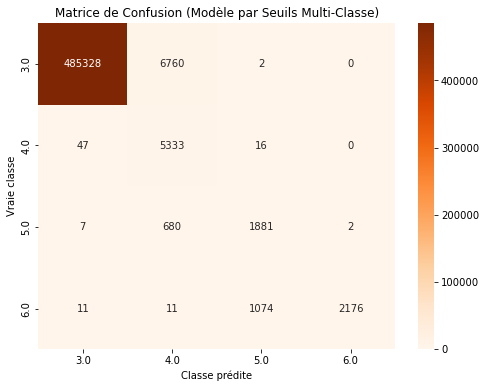

In [8]:
# --- Préparation des données ---
df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])

cutoff_date = pd.to_datetime('2025-03-08')
train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()
predict_base_df = df_global[df_global['heure_arrondie'] >= cutoff_date].copy()


# --- Calcul des seuils médians par tronçon ET par code couleur ---
seuils_par_troncon = train_df.groupby(['id', 'code_couleur'])['taux_occupation'].median().reset_index()
seuils_par_troncon.rename(columns={'taux_occupation': 'seuil_median_occupation'}, inplace=True)


# --- Prédiction basée sur les seuils multi-classe ---
predict_df_merged = pd.merge(
    predict_base_df,
    df_prediction_taux_occupation,
    on=['heure_arrondie', 'nom_du_troncon'],
    how='inner'
)

def predict_with_thresholds_multiclass(row, seuils_df):
    taux_pred = row['taux_occupation_pred']
    troncon_id = row['id']
    
    seuils_troncon = seuils_df[seuils_df['id'] == troncon_id]
    
    if seuils_troncon.empty:
        return 3 # On prédit 'fluide' par défaut si le tronçon est inconnu
    
    distances = (seuils_troncon['seuil_median_occupation'] - taux_pred).abs()
    closest_idx = distances.idxmin()
    
    return seuils_troncon.loc[closest_idx, 'code_couleur'] # On retourne le 'code_couleur' du seuil le plus proche

predictions = predict_df_merged.apply(predict_with_thresholds_multiclass, axis=1, args=(seuils_par_troncon,))
print("Prédictions multi-classe par seuils terminées.")


# --- Évaluation de la solution ---
y_true = predict_df_merged['code_couleur']
y_pred = predictions

print("\n--- Rapport de Classification (Modèle par Seuils Multi-Classe) ---")
print(classification_report(y_true, y_pred))

print("\n--- Matrice de Confusion (Modèle par Seuils Multi-Classe) ---")
labels = sorted(y_true.unique())
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion (Modèle par Seuils Multi-Classe)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

## Test 4 : Méthode sans machine Learning : application d'un 'seuil' de classification par troncon en fonction tu taux d'occupation median passé. Cible binaire : Fluide/non fluide

## Étape 1: Transformation en problème binaire à partir de 'etat_du_trafic' ##
Distribution de la nouvelle cible binaire sur df_global:
is_not_fluid
0    1836582
1      44157
Name: count, dtype: int64

## Étape 2: Calcul des seuils médians par tronçon ##
Table des seuils binaires calculée.

## Étape 3: Application de la logique de prédiction par seuils ##

## Étape 4: Évaluation du modèle de référence binaire ##

--- Rapport de Classification (Modèle par Seuils Binaire) ---
                precision    recall  f1-score   support

    Fluide (0)       0.98      1.00      0.99    861646
Non Fluide (1)       1.00      0.00      0.00     19058

      accuracy                           0.98    880704
     macro avg       0.99      0.50      0.49    880704
  weighted avg       0.98      0.98      0.97    880704


--- Matrice de Confusion (Modèle par Seuils Binaire) ---


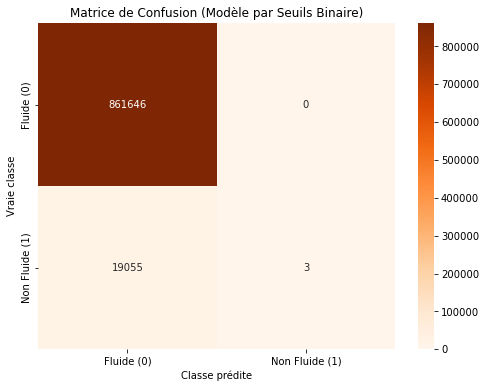

In [9]:
# --- ÉTAPE 1: Transformation du problème en binaire ---
print("## Étape 1: Transformation en problème binaire à partir de 'etat_du_trafic' ##")

def map_to_binary_from_etat(etat):
  if etat == 'Fluide':
    return 0  # Représente 'fluide'
  else:
    return 1  # Représente 'non fluide'

df_global['is_not_fluid'] = df_global['etat_du_trafic'].apply(map_to_binary_from_etat)
print("Distribution de la nouvelle cible binaire sur df_global:")
print(df_global['is_not_fluid'].value_counts())


# --- ÉTAPE 2: Préparation des données et calcul des seuils ---
print("\n## Étape 2: Calcul des seuils médians par tronçon ##")
cutoff_date = pd.to_datetime('2025-03-08')
train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()

# Calculer les seuils basés sur la nouvelle colonne binaire
seuils_par_troncon = train_df.groupby(['id', 'is_not_fluid'])['taux_occupation'].median().reset_index()
seuils_par_troncon.rename(columns={'taux_occupation': 'seuil_median_occupation'}, inplace=True)
print("Table des seuils binaires calculée.")


# --- ÉTAPE 3: Prédiction basée sur les seuils ---
print("\n## Étape 3: Application de la logique de prédiction par seuils ##")

# Il faut l'id du tronçon dans le dataframe de prédiction, on le récupère de df_global
df_prediction_with_id = pd.merge(
    df_prediction_taux_occupation,
    df_global[['nom_du_troncon', 'id']].drop_duplicates(),
    on='nom_du_troncon',
    how='left'
)

# Fonction qui applique la logique de prédiction pour une seule ligne
def predict_with_thresholds_binary(row, seuils_df):
    taux_pred = row['taux_occupation_pred']
    troncon_id = row['id']
    
    seuils_troncon = seuils_df[seuils_df['id'] == troncon_id]
    
    if seuils_troncon.empty:
        return 0 # On prédit 'fluide' par défaut si le tronçon est inconnu
    
    # Calculer la distance entre le taux prédit et chaque seuil
    distances = (seuils_troncon['seuil_median_occupation'] - taux_pred).abs()
    
    # Trouver l'index du seuil le plus proche
    closest_idx = distances.idxmin()
    
    # Retourner la classe binaire du seuil le plus proche
    return seuils_troncon.loc[closest_idx, 'is_not_fluid']

# Appliquer la fonction pour obtenir les prédictions
predictions = df_prediction_with_id.apply(predict_with_thresholds_binary, axis=1, args=(seuils_par_troncon,))
df_prediction_with_id['prediction'] = predictions.astype(int)


# --- ÉTAPE 4: Évaluation de la solution ---
print("\n## Étape 4: Évaluation du modèle de référence binaire ##")

# Pour évaluer, il nous faut la vraie valeur de 'is_not_fluid' pour la période de test
# On la récupère depuis df_global
y_true_df = df_global[df_global['heure_arrondie'] >= cutoff_date][['heure_arrondie', 'nom_du_troncon', 'is_not_fluid']]
evaluation_df = pd.merge(
    df_prediction_with_id,
    y_true_df,
    on=['heure_arrondie', 'nom_du_troncon'],
    how='inner'
)

y_true = evaluation_df['is_not_fluid']
y_pred = evaluation_df['prediction']

print("\n--- Rapport de Classification (Modèle par Seuils Binaire) ---")
target_names = ['Fluide (0)', 'Non Fluide (1)']
print(classification_report(y_true, y_pred, target_names=target_names))

print("\n--- Matrice de Confusion (Modèle par Seuils Binaire) ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion (Modèle par Seuils Binaire)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

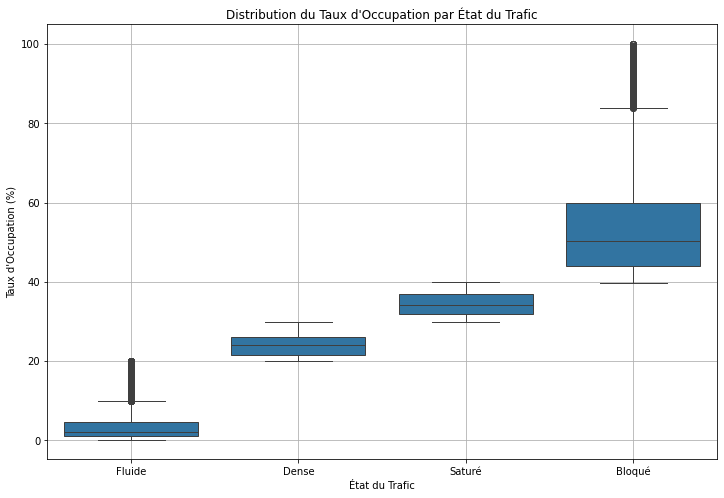

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(x='etat_du_trafic', y='taux_occupation', data=df_global, 
            order=['Fluide', 'Dense', 'Saturé', 'Bloqué']) # Pour un affichage logique
plt.title("Distribution du Taux d'Occupation par État du Trafic")
plt.xlabel("État du Trafic")
plt.ylabel("Taux d'Occupation (%)")
plt.grid(True)
plt.show()

In [8]:
def predict_with_simple_rules(taux_occupation):
    if taux_occupation < 20:  # Estimé à partir du graphique
        return 3 # Fluide
    elif taux_occupation < 30: # Estimé à partir du graphique
        return 4 # Dense
    elif taux_occupation < 45: # Estimé à partir du graphique
        return 5 # Saturé
    else:
        return 6 # Bloqué

# Et ensuite l'appliquer à vos données prédites
df_prediction_taux_occupation['etat_trafic_predit'] = df_prediction_taux_occupation['taux_occupation_pred'].apply(predict_with_simple_rules)

In [9]:
df_prediction_taux_occupation

,heure_arrondie,nom_du_troncon,taux_occupation_reel,taux_occupation_pred,etat_trafic_predit
0,2025-03-08 00:00:00,3 Continents I,-0.109032,-0.102010,3
1,2025-03-08 00:15:00,3 Continents I,-0.141105,-0.246060,3
2,2025-03-08 00:30:00,3 Continents I,-0.012810,-0.219238,3
3,2025-03-08 00:45:00,3 Continents I,-0.269400,-0.123357,3
4,2025-03-08 01:00:00,3 Continents I,-0.325530,-0.327646,3
...,...,...,...,...,...
431419,2025-03-13 22:45:00,Voltaire I1,-0.429769,-0.443231,3
431420,2025-03-13 23:00:00,Voltaire I1,-0.373640,-0.413999,3
431421,2025-03-13 23:15:00,Voltaire I1,-0.317511,-0.403318,3
431422,2025-03-13 23:30:00,Voltaire I1,-0.261382,-0.383616,3
